In [475]:
import graphlab

In [476]:
sales = graphlab.SFrame('kc_house_data.gl/')

 # Linear Regression Function

In [477]:
train_data,test_data = sales.random_split(.8,seed=0)

In [478]:
def simple_linear_regression(input_feature, output):
      
    prod = input_feature*output
    omean = output.mean()
    imean = input_feature.mean()
    sp = prod.sum()

    sqval = input_feature*input_feature
    sq = sqval.sum()
    sqin = input_feature.sum()
    sq1 = sqin*imean
    sqvalm = imean*imean
    sm = omean*sqin
 
    slope = (sp - sm)/(sq - sq1)
    
    intercept = omean - (slope*imean)
    
    return (intercept, slope)


In [479]:
test_feature = graphlab.SArray(range(5))
test_output = graphlab.SArray(1 + 1*test_feature)
(test_intercept, test_slope) =  simple_linear_regression(test_feature, test_output)
print "Intercept: " + str(test_intercept)
print "Slope: " + str(test_slope)

Intercept: 1.0
Slope: 1.0


In [480]:
sqft_intercept, sqft_slope = simple_linear_regression(train_data['sqft_living'], train_data['price'])

print "Intercept: " + str(sqft_intercept)
print "Slope: " + str(sqft_slope)

Intercept: -47116.0765749
Slope: 281.958838568


# Predicting Values

In [481]:
def get_regression_predictions(input_feature, intercept, slope):
    predicted_values = intercept + (slope*input_feature)
    
    return predicted_values

# Predict Squarefeet Given Price

In [482]:
def inverse_regression_predictions(output, intercept, slope):
    # solve output = intercept + slope*input_feature for input_feature. Use this equation to compute the inverse predictions:
    estimated_feature = (output - intercept)/slope

    return estimated_feature

#Regression Using Gradient Descent

#Using Numpy

In [483]:
import numpy as np

In [484]:
def get_numpy_data(data_sframe, features, output):
    #adding constant column
    data_sframe['constant'] = 1 
    #adding column to feature list
    features = ['constant'] + features 
    # selecting columns of data_sframe given by the features list into the SFrame features_sframe
    features_sframe = data_sframe[features]
    # features_sframe into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assigning data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    #  SArray into a numpy array
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

Testing

In [485]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price')
print example_features[0,:] 
print example_output[0] 

[  1.00000000e+00   1.18000000e+03]
221900.0


#Predict Output With Regression Weights

In [486]:
my_weights = np.array([1., 1.]) #example test
my_features = example_features[0,] 
predicted_value = np.dot(my_features, my_weights)
print predicted_value

1181.0


In [487]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

Test

In [488]:
test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1181.0
print test_predictions[1] # should be 2571.0

1181.0
2571.0


#Calculating Derivative

In [489]:
def feature_derivative(errors, feature):
    derivative = 2*np.dot(errors,feature)
    return(derivative)

Test

In [490]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output 
feature = example_features[:,0] # computing the derivative with respect to 'constant'
derivative = feature_derivative(errors, feature)
print derivative
print -np.sum(example_output)*2 # should be the same as derivative

-23345850022.0
-23345850022.0


# Gradient Descent

In [491]:
from math import sqrt

In [492]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    weights = np.array(initial_weights) # convert to numpy array
    while not converged:
        # computing predictions
        predictions = predict_output(feature_matrix,weights)
        # computing
        errors = predictions - output
        gradient_sum_squares = 0 # initialization
        # while tolerance not reached, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # computing the derivative for weight[i]
            derivative = feature_derivative(errors,feature_matrix[:,i])
            # adding squared value of the derivative to the gradient magnitude (for assessing convergence)
            gradient_sum_squares = gradient_sum_squares + (derivative*derivative)
            # subtracting the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        # computing the square-root of the gradient sum of squares to get the gradient matnigude
        gradient_magnitude = sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
    return(weights)

#Multiple Regression Using Gradient Descent

In [493]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

In [494]:
weightz = regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance)

In [495]:
(test_simple_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [496]:
weights2 = regression_gradient_descent(test_simple_feature_matrix, test_output, weightz, step_size, tolerance)

In [497]:
predict_output(test_simple_feature_matrix, weightz)

array([ 366651.41203656,  762662.39786164,  386312.09499712, ...,
        682087.39928241,  585579.27865729,  216559.20396617])

#Polynomial Regressing Selecting The Degree

# polynomial_sframe function

In [498]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1 and initialize SFrame
    poly_sframe = graphlab.SFrame()
    # set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] = feature
    # check if degree > 1
    if degree > 1:
        # loop over the remaining degrees
        # range usually starts at 0 and stops at the endpoint -1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            name = 'power_' + str(power)
            # assigning poly_sframe[name] to the appropriate power of feature
        poly_sframe[name] = feature.apply(lambda x: x**degree)
    return poly_sframe

Test

In [499]:
tmp = graphlab.SArray([1., 2., 3.])
tmp_cubed = tmp.apply(lambda x: x**3)
print tmp
print tmp_cubed

[1.0, 2.0, 3.0]
[1.0, 8.0, 27.0]


In [500]:
print polynomial_sframe(tmp, 3)

+---------+---------+
| power_1 | power_3 |
+---------+---------+
|   1.0   |   1.0   |
|   2.0   |   8.0   |
|   3.0   |   27.0  |
+---------+---------+
[3 rows x 2 columns]



# Visualizing Polynomial Regression

In [501]:
sales = sales.sort(['sqft_living', 'price'])

In [502]:
poly1_data = polynomial_sframe(sales['sqft_living'], 1)
poly1_data['price'] = sales['price'] # adding price to the data since it's the target

In [503]:
model1 = graphlab.linear_regression.create(poly1_data, target = 'price', features = ['power_1'], validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.012000     | 4362074.696077     | 261440.790724 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [504]:
model1.get("coefficients")

name,index,value,stderr
(intercept),None,-43579.0852515,4402.68969743
power_1,None,280.622770886,1.93639855513


In [505]:
import matplotlib.pyplot as plt
%matplotlib inline

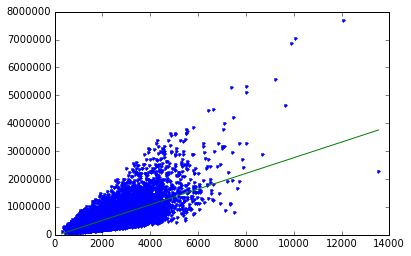

In [506]:
plt.plot(poly1_data['power_1'],poly1_data['price'],'.',
        poly1_data['power_1'], model1.predict(poly1_data),'-')

In [507]:
poly2_data = polynomial_sframe(sales['sqft_living'], 2)
my_features = poly2_data.column_names()
poly2_data['price'] = sales['price'] 
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.014000     | 5913020.984255     | 250948.368758 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [508]:
model2.get("coefficients")

name,index,value,stderr
(intercept),None,199222.496445,7058.00483552
power_1,None,67.9940640677,5.28787201316
power_2,None,0.0385812312789,0.000898246547032


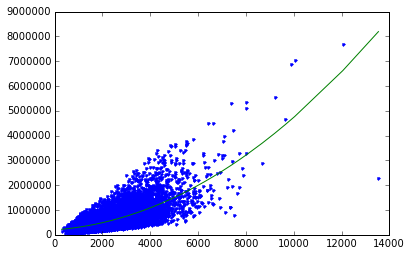

In [509]:
plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

In [510]:
poly2_data = polynomial_sframe(sales['sqft_living'], 3)
my_features = poly2_data.column_names()
poly2_data['price'] = sales['price'] 
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.011001     | 6687796.841446     | 254179.386884 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

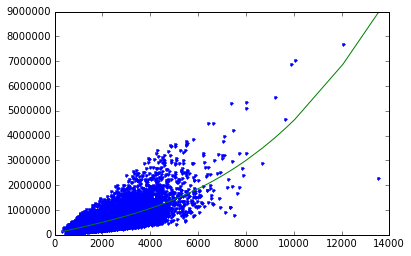

In [511]:
plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

In [512]:
poly2_data = polynomial_sframe(sales['sqft_living'], 15)
my_features = poly2_data.column_names() 
poly2_data['price'] = sales['price'] 
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.013001     | 4460865.155262     | 261409.025371 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

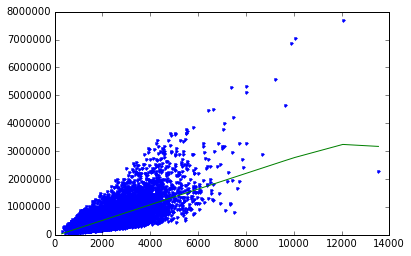

In [513]:
plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

# Changing The Data And Re-Learning

In [514]:
#splitting the data into 4 different sets for analysis
set_1,set_2 = sales.random_split(0.5,seed=0)
set_1,set_3 = set_1.random_split(0.5,seed=0)
set_2,set_4 = set_2.random_split(0.5,seed=0)

Linear regression:

--------------------------------------------------------

Number of examples          : 5404

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 4361931.033848     | 267710.403033 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

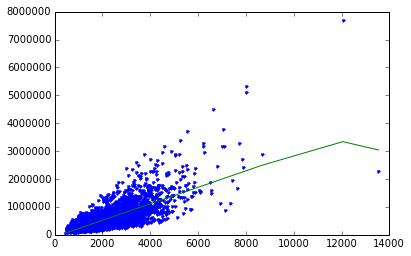

In [515]:
poly2_data = polynomial_sframe(set_1['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_1['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

model2.get("coefficients")

plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

Linear regression:

--------------------------------------------------------

Number of examples          : 5409

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.003001     | 2751531.313810     | 260544.348189 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

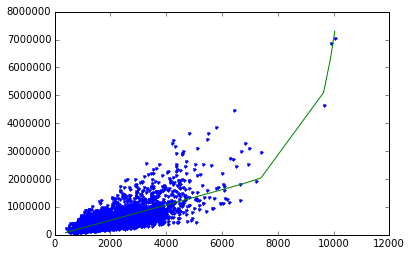

In [516]:
poly2_data = polynomial_sframe(set_2['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_2['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

model2.get("coefficients")

plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

Linear regression:

--------------------------------------------------------

Number of examples          : 5398

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.003000     | 2295628.184744     | 242918.457165 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

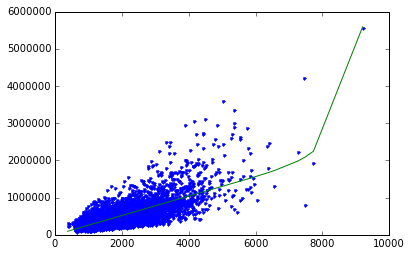

In [517]:
poly2_data = polynomial_sframe(set_3['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_3['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

model2.get("coefficients")

plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

Linear regression:

--------------------------------------------------------

Number of examples          : 5402

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.004000     | 2807564.310416     | 253305.176720 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

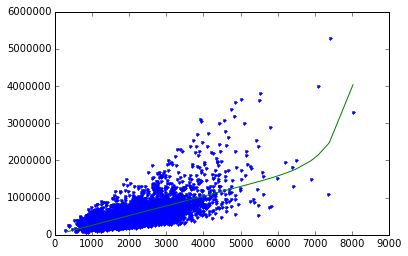

In [518]:
poly2_data = polynomial_sframe(set_4['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_4['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

model2.get("coefficients")

plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

#Selecting Polynomial Degree

In [519]:
training_validation,test = sales.random_split(0.9,seed=1)
training,validation = sales.random_split(0.5,seed=1)

In [520]:
def get_residual_sum_of_squares(model, data, outcome):
    predictions = model.predict(data)
    # computing the residuals/errors
    r = outcome - predictions
    #squaring and adding up
    rs = r*r
    RSS = rs.sum()
    return(RSS)    

Testing On Validation Set And Degree With Lowest RSS is Chosen

In [521]:
for degree in range(1,16):
    poly2_data = polynomial_sframe(training['sqft_living'], degree)
    my_features = poly2_data.column_names() 
    poly2_data['price'] = training['price'] 
    model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, verbose = False,validation_set = None)
    poly_val_data = polynomial_sframe(validation['sqft_living'], degree)
    rss_validate = get_residual_sum_of_squares(model2, poly_val_data, validation['price'])
    print rss_validate

7.26788501911e+14
7.12043762017e+14
7.57236432022e+14
8.04862620252e+14
8.4005568193e+14
8.66440537856e+14
8.91691171406e+14
9.20634915898e+14
9.56118513426e+14
1.00040381741e+15
1.05588343701e+15
1.1254300724e+15
1.21262594708e+15
1.3219795693e+15
1.45917555814e+15


Testing On Test Set And Degree With Lowest RSS is Chosen

In [522]:
poly2_data = polynomial_sframe(training['sqft_living'],2)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = training['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = my_features, verbose = False,validation_set = None)
poly_test_data = polynomial_sframe(test['sqft_living'],2)
rss_test = get_residual_sum_of_squares(model2, poly_test_data, test['price'])
print rss_test

1.27315205222e+14


#Ridge Regression Removing Overfitting

#Checking Overfitting

In [523]:
(semi_split1, semi_split2) = sales.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)
l2_small_penalty = 1e-5

In [524]:
poly2_data = polynomial_sframe(set_1['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_1['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = l2_small_penalty,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5404

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 4229869.996022     | 267984.222453 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,-67961.9168775,8662.77077856
power_1,None,293.617586793,3.75384178617


In [525]:
poly2_data = polynomial_sframe(set_2['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_2['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = l2_small_penalty,
                                           validation_set = None)

model2.get("coefficients")


Linear regression:

--------------------------------------------------------

Number of examples          : 5398

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 3131682.950937     | 246762.851552 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,-18029.1562025,8404.92280451
power_1,None,266.994152746,3.69831415976


In [526]:
poly2_data = polynomial_sframe(set_3['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_3['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = l2_small_penalty,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5409

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 4192850.894826     | 274005.503275 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,-64157.5447558,9206.23250037
power_1,None,292.211817722,4.05612573554


In [527]:
poly2_data = polynomial_sframe(set_3['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_3['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = l2_small_penalty,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5409

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.001000     | 4192850.894826     | 274005.503275 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,-64157.5447558,9206.23250037
power_1,None,292.211817722,4.05612573554


#Ridge Regression

Ridge Regression Achived By Varying L2 Penalty

In [528]:
poly2_data = polynomial_sframe(set_1['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_1['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = 1e5,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5404

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 7125598.824348     | 389377.857700 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,540851.935773,12586.9019326
power_1,None,2.78416928453,5.4542870452


In [529]:
poly2_data = polynomial_sframe(set_2['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_2['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = 1e5,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5398

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 5015576.158935     | 344535.897653 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,533424.72285,11735.1441067
power_1,None,2.2825128495,5.16367022352


In [530]:
poly2_data = polynomial_sframe(set_3['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_3['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = 1e5,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5409

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.003000     | 6499737.219634     | 381949.370463 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,536993.509025,12833.0076069
power_1,None,2.56666049212,5.65402757497


In [531]:
poly2_data = polynomial_sframe(set_4['sqft_living'], 15)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['price'] = set_4['price'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'price', features = ['power_1'], l2_penalty = 1e5,
                                           validation_set = None)

model2.get("coefficients")

Linear regression:

--------------------------------------------------------

Number of examples          : 5402

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.002000     | 4755355.570431     | 343653.037881 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,528706.255679,12029.426997
power_1,None,2.15672177122,5.36051707461


# Selecting L2 Penalty Via Cross-Validation

In [532]:
(train_valid, test) = sales.random_split(.9, seed=1)
train_valid_shuffled = graphlab.toolkits.cross_validation.shuffle(train_valid, random_seed=1)

In [533]:
#generating splits
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in xrange(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print i, (start, end)

0 (0, 1938)
1 (1939, 3878)
2 (3879, 5817)
3 (5818, 7757)
4 (7758, 9697)
5 (9698, 11636)
6 (11637, 13576)
7 (13577, 15515)
8 (15516, 17455)
9 (17456, 19395)


In [534]:
train_valid_shuffled[0:10]

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
2780400035,2014-05-05 00:00:00+00:00,665000.0,4.0,2.5,2800.0,5900,1,0
1703050500,2015-03-21 00:00:00+00:00,645000.0,3.0,2.5,2490.0,5978,2,0
5700002325,2014-06-05 00:00:00+00:00,640000.0,3.0,1.75,2340.0,4206,1,0
0475000510,2014-11-18 00:00:00+00:00,594000.0,3.0,1.0,1320.0,5000,1,0
0844001052,2015-01-28 00:00:00+00:00,365000.0,4.0,2.5,1904.0,8200,2,0
2781280290,2015-04-27 00:00:00+00:00,305000.0,3.0,2.5,1610.0,3516,2,0
2214800630,2014-11-05 00:00:00+00:00,239950.0,3.0,2.25,1560.0,8280,2,0
2114700540,2014-10-21 00:00:00+00:00,366000.0,3.0,2.5,1320.0,4320,1,0
2596400050,2014-07-30 00:00:00+00:00,375000.0,3.0,1.0,1960.0,7955,1,0
4140900050,2015-01-26 00:00:00+00:00,440000.0,4.0,1.75,2180.0,10200,1,0


In [535]:
#4th segment set aside for validation
validation4 = train_valid_shuffled[5818 : 7758]

In [536]:
#test
print int(round(validation4['price'].mean(), 0)) #should be $536,234

536234


In [537]:
#selecting all segments except 4th
n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print first_two.append(last_two)

+------------+---------------------------+-----------+----------+-----------+
|     id     |            date           |   price   | bedrooms | bathrooms |
+------------+---------------------------+-----------+----------+-----------+
| 2780400035 | 2014-05-05 00:00:00+00:00 |  665000.0 |   4.0    |    2.5    |
| 1703050500 | 2015-03-21 00:00:00+00:00 |  645000.0 |   3.0    |    2.5    |
| 4139480190 | 2014-09-16 00:00:00+00:00 | 1153000.0 |   3.0    |    3.25   |
| 7237300290 | 2015-03-26 00:00:00+00:00 |  338000.0 |   5.0    |    2.5    |
+------------+---------------------------+-----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    2800.0   |   5900   |   1    |     0      |  0   |     3     |   8   |    1660    |
|    2490.0   |   59

In [538]:
train4 = train_valid_shuffled[0 : 5818].append(train_valid_shuffled[7758 : 19396])

In [539]:
#test
print int(round(train4['price'].mean(), 0)) # should be $539,450

539450


In [540]:
def get_RSS(prediction, output):
    residual = output - prediction
    # square the residuals and add them up
    RS = residual*residual
    RSS = RS.sum()
    return(RSS)

def k_fold_cross_validation(k, l2_penalty, data, features_list):
    n = len(data)
    RSS = 0
    for i in xrange(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        validation=data[start:end+1]
        train=data[0:start].append(data[end+1:n])
        model = graphlab.linear_regression.create(train, target='price', features = features_list, l2_penalty=l2_penalty,validation_set=None,verbose = False)
        predictions=model.predict(validation)
        A =get_RSS(predictions,validation['price'])
        RSS = RSS + A
        
    Val_err = RSS/k
    return Val_err

In [541]:
poly1_data = polynomial_sframe(train_valid_shuffled['sqft_living'], 15) 
my_features = poly1_data.column_names() 
poly1_data['price'] = train_valid_shuffled['price']
model1 = graphlab.linear_regression.create(poly1_data, target = 'price', features = my_features, validation_set = None, l2_penalty=1000)
Val_err = k_fold_cross_validation(10, 1000, poly1_data, my_features)
print Val_err

Linear regression:

--------------------------------------------------------

Number of examples          : 19396

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.012001     | 4972525.160451     | 270929.934900 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

2.47205402011e+14


# Ridge Regression Via Gradient Descent

# Computing the Derivative

In [542]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if(feature_is_constant == True):
        derivative = 2*np.dot(errors,feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2*np.dot(errors,feature) + 2*l2_penalty*weight
    return derivative

Testing

In [543]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.65541667824e+13
-5.65541667824e+13

-22446749336.0
-22446749336.0


# Gradient Descent

In [544]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    count = 0
    finish = False
    while not finish:
    #while not reached maximum number of iterations
        # computing the predictions
        predictions = predict_output(feature_matrix,weights)
        # computing the errors
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # computing the derivative for weight[i].
            if(i==0):
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors,feature_matrix[:,i],weights[i],l2_penalty,feature_is_constant)
            # subtracting the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        count = count + 1
        if(count == max_iterations):
            finish = True
    return weights

# Visualizing effect of L2 penalty

In [545]:
simple_features = ['sqft_living']
my_output = 'price'

In [546]:
train_data,test_data = sales.random_split(.8,seed=0)

In [547]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [548]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

In [549]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 0, 
                                                             max_iterations)
simple_weights_0_penalty

array([ -1.08717115e-01,   2.62418005e+02])

In [550]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 1e11, 
                                                       max_iterations)
simple_weights_high_penalty

array([   9.80190359,  124.33440529])

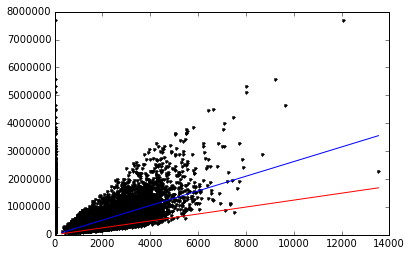

In [551]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [552]:
def get_residual_sum_of_squares(weights,data, outcome):
    predictions = np.dot(data,weights)
    # computing the residuals
    r = outcome - predictions
    #squaring and adding up
    rs = r*r
    RSS = rs.sum()
    return(RSS)    
rss1 = get_residual_sum_of_squares(initial_weights,simple_test_feature_matrix,test_output)
rss1

1858519206266080.0

In [553]:
rss2 = get_residual_sum_of_squares(simple_weights_0_penalty,simple_test_feature_matrix,test_output)
rss2

326034461837293.5

In [554]:
rss3 = get_residual_sum_of_squares(simple_weights_high_penalty,simple_test_feature_matrix,test_output)
rss3


760143524730155.5

#Multiple Regression With L2 Penalty

In [555]:
model_features = ['sqft_living', 'sqft_living15'] 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [556]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

In [557]:
multipe_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 0, 
                                                       max_iterations)
multipe_weights_0_penalty

array([  -0.33006808,  236.46462743,   29.09218105])

In [558]:
multipe_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 1e11, 
                                                       max_iterations)
multipe_weights_high_penalty

array([  6.76942188,  91.12672268,  78.58883803])

In [559]:
predict_output(test_feature_matrix,multipe_weights_0_penalty)

array([  161467.51803945,   139394.73223315,   207656.79483868, ...,
        2017469.4551116 ,  2470713.33721104,  2488436.8008866 ])

In [560]:
predict_output(test_feature_matrix,multipe_weights_high_penalty)

array([  178795.01888035,   113691.66215877,   270710.34407837, ...,
        1057772.65154296,  1258043.38140901,  1223773.19861053])

#Feature Selection And Lasso Regression

#Creating New Features

In [561]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

# Learning Regression Weights With L1 Penalty

In [562]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

In [563]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.255015     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.277016     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.301018     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.333019     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.358021     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.389023     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [564]:
model_all.coefficients.print_rows(num_rows=18,num_columns=3)

+------------------+-------+---------------+-----+
|       name       | index |     value     | ... |
+------------------+-------+---------------+-----+
|   (intercept)    |  None |  274873.05595 | ... |
|     bedrooms     |  None |      0.0      | ... |
| bedrooms_square  |  None |      0.0      | ... |
|    bathrooms     |  None | 8468.53108691 | ... |
|   sqft_living    |  None | 24.4207209824 | ... |
| sqft_living_sqrt |  None | 350.060553386 | ... |
|     sqft_lot     |  None |      0.0      | ... |
|  sqft_lot_sqrt   |  None |      0.0      | ... |
|      floors      |  None |      0.0      | ... |
|  floors_square   |  None |      0.0      | ... |
|    waterfront    |  None |      0.0      | ... |
|       view       |  None |      0.0      | ... |
|    condition     |  None |      0.0      | ... |
|      grade       |  None | 842.068034898 | ... |
|    sqft_above    |  None | 20.0247224171 | ... |
|  sqft_basement   |  None |      0.0      | ... |
|     yr_built     |  None |   

# Selecting L1 penalty

In [565]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

In [566]:

import numpy as np

def get_RSS(prediction, output):
    residual = output - prediction
    # square the residuals and add them up
    RS = residual*residual
    RSS = RS.sum()
    return(RSS)

for l1_penalty in np.logspace(1, 7, num=13):
    A = 0 
    print l1_penalty
    model_all = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False,
                                              l2_penalty=0, l1_penalty=l1_penalty)
    predictions=model_all.predict(validation)
    A = get_RSS(predictions,validation['price'])
    print A

10.0
7.05916519588e+14
31.6227766017
7.05916519803e+14
100.0
7.05916520482e+14
316.227766017
7.0591652263e+14
1000.0
7.05916529423e+14
3162.27766017
7.05916550905e+14
10000.0
7.05916618839e+14
31622.7766017
7.059168337e+14
100000.0
7.05917513484e+14
316227.766017
7.05919666477e+14
1000000.0
7.05926508132e+14
3162277.66017
7.05948476296e+14
10000000.0
7.06021275191e+14


In [567]:
#No. of non zero weights
model_all.coefficients["value"].nnz()

18

# Limiting the number of nonzero weights

In [568]:
max_nonzeros = 7

In [569]:
l1_penalty_values = np.logspace(8, 10, num=20)
l1_penalty_values

array([  1.00000000e+08,   1.27427499e+08,   1.62377674e+08,
         2.06913808e+08,   2.63665090e+08,   3.35981829e+08,
         4.28133240e+08,   5.45559478e+08,   6.95192796e+08,
         8.85866790e+08,   1.12883789e+09,   1.43844989e+09,
         1.83298071e+09,   2.33572147e+09,   2.97635144e+09,
         3.79269019e+09,   4.83293024e+09,   6.15848211e+09,
         7.84759970e+09,   1.00000000e+10])

In [570]:
#Finding possible L1 values
for l1_penalty in np.logspace(8, 10, num=20):
    model3 = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set= None, verbose = False, 
                                              l2_penalty=0, l1_penalty=l1_penalty)
    a = model3.coefficients["value"].nnz()
    rss_mod3 = get_RSS(predictions,validation['price'])
    print rss_mod3
    print a

7.06021275191e+14
18
7.06021275191e+14
18
7.06021275191e+14
18
7.06021275191e+14
18
7.06021275191e+14
17
7.06021275191e+14
17
7.06021275191e+14
17
7.06021275191e+14
17
7.06021275191e+14
17
7.06021275191e+14
16
7.06021275191e+14
16
7.06021275191e+14
16
7.06021275191e+14
14
7.06021275191e+14
12
7.06021275191e+14
11
7.06021275191e+14
6
7.06021275191e+14
5
7.06021275191e+14
3
7.06021275191e+14
1
7.06021275191e+14
1


In [571]:
l1_penalty_min = 2.97635144e+09
l1_penalty_max = 3.79269019e+09

# Exploring The Narrow Range of Values to Find The Solution With The Right Number of Non-Zeros That Has Lowest RSS on The Validation Set 

In [572]:
#Exploring found l1 penalties
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)
l1_penalty_values

array([  2.97635144e+09,   3.01931664e+09,   3.06228183e+09,
         3.10524703e+09,   3.14821223e+09,   3.19117743e+09,
         3.23414262e+09,   3.27710782e+09,   3.32007302e+09,
         3.36303822e+09,   3.40600341e+09,   3.44896861e+09,
         3.49193381e+09,   3.53489901e+09,   3.57786420e+09,
         3.62082940e+09,   3.66379460e+09,   3.70675980e+09,
         3.74972499e+09,   3.79269019e+09])

In [573]:
for l1_penalty in np.linspace(l1_penalty_min,l1_penalty_max,20):
    A = 0
    predictions = 0
    model_all = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False,
                                              l2_penalty=0, l1_penalty=l1_penalty)
    predictions=model_all.predict(validation)
    A = get_RSS(predictions,validation['price'])
    if model_all['coefficients']['value'].nnz() <= 7:
        print l1_penalty
        print A
        print model_all['coefficients']['value'].nnz()

3620829400.53
1.18665102599e+15
6
3663794597.89
1.18983337629e+15
6
3706759795.26
1.19315080261e+15
6
3749724992.63
1.19692433779e+15
6
3792690190.0
1.20089708397e+15
6


In [574]:
model4.coefficients.print_rows(num_rows=18,num_columns=3)

+------------------+-------+---------------+-----+
|       name       | index |     value     | ... |
+------------------+-------+---------------+-----+
|   (intercept)    |  None |  196517.54727 | ... |
|     bedrooms     |  None | 2021.65639306 | ... |
| bedrooms_square  |  None | 570.871521794 | ... |
|    bathrooms     |  None |  16731.611212 | ... |
|   sqft_living    |  None | 32.8398823356 | ... |
| sqft_living_sqrt |  None | 761.525620141 | ... |
|     sqft_lot     |  None |      0.0      | ... |
|  sqft_lot_sqrt   |  None |      0.0      | ... |
|      floors      |  None | 3702.36451836 | ... |
|  floors_square   |  None |      0.0      | ... |
|    waterfront    |  None |      0.0      | ... |
|       view       |  None |  7573.8726523 | ... |
|    condition     |  None |      0.0      | ... |
|      grade       |  None | 3405.87980003 | ... |
|    sqft_above    |  None | 30.9500468071 | ... |
|  sqft_basement   |  None | 14.6084256582 | ... |
|     yr_built     |  None |   

# Normalize Features

In [575]:
import numpy as np
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    features = feature_matrix / norms
    return features, norms

Test

In [576]:
features, norms = normalize_features(np.array([[3.,6.,9.],[4.,8.,12.]]))
print features
# should print
# [[ 0.6  0.6  0.6]
#  [ 0.8  0.8  0.8]]
print norms
# should print
# [5.  10.  15.]

[[ 0.6  0.6  0.6]
 [ 0.8  0.8  0.8]]
[  5.  10.  15.]


# Implementing Coordinate Descent With Normalized Features

# Effect of L1 penalty

In [577]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)

In [578]:
simple_feature_matrix, norms = normalize_features(simple_feature_matrix)

In [579]:
weights = np.array([1., 4., 1.])

In [580]:
prediction = predict_output(simple_feature_matrix, weights)

In [581]:
ro = [0 for i in range((simple_feature_matrix.shape)[1])]
for j in range((simple_feature_matrix.shape)[1]):    
    ro[j] = (simple_feature_matrix[:,j] * (output - prediction + (weights[j] * simple_feature_matrix[:,j]))).sum()
print ro

[79400300.034929171, 87939470.772991076, 80966698.675965652]


#Single Coordinate Descent Step

In [582]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    # computing prediction
    prediction = predict_output(feature_matrix, weights)    
    # computing ro[i]
    ro_i = np.sum(feature_matrix[:,i]*(output - prediction + weights[i]*feature_matrix[:,i]))
    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i 
    elif ro_i < -l1_penalty/2.:
        new_weight_i = ro_i + (l1_penalty/2)    
    elif ro_i > l1_penalty/2.:
        new_weight_i = ro_i - (l1_penalty/2)    
    else:
        new_weight_i = 0.
    return new_weight_i

Test

In [583]:
# should print 0.425558846691
import math
print lasso_coordinate_descent_step(1, np.array([[3./math.sqrt(13),1./math.sqrt(10)],[2./math.sqrt(13),3./math.sqrt(10)]]), 
                                   np.array([1., 1.]), np.array([1., 4.]), 0.1)

0.425558846691


# Cyclical coordinate descent

In [584]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    weights = initial_weights.copy()    
    # converged condition variable    
    converged  = False        
    while not converged:         
        max_change = 0
        for i in range(len(weights)):
            old_weights_i = weights[i] 
            weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)                        
            change_i = np.abs(old_weights_i - weights[i])             
            if change_i > max_change:                
                max_change = change_i        
        if max_change < tolerance:              
            converged = True     
    return weights

In [585]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
initial_weights = np.zeros(3)
l1_penalty = 1e7
tolerance = 1.0

In [586]:
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)
(normalized_simple_feature_matrix, simple_norms) = normalize_features(simple_feature_matrix) # normalize features

In [587]:
#Running Implementation
weights = lasso_cyclical_coordinate_descent(normalized_simple_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)
print weights

[ 21624998.36636291  63157246.78545421         0.        ]


# Predicting House Prices Using K-Nearest Neighbors Regression

In [588]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

In [589]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In [590]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

#Compute a Single Distance

In [591]:
#query house taken as first house of test set
print features_test[0]

[ 0.00850979  0.00242439  0.00283763  0.00157689  0.00132806  0.00536944
  0.          0.          0.00734509  0.00549402  0.00181961  0.
  0.00829766  0.          0.00850823 -0.00851656  0.00574732  0.00188654]


In [592]:
#10th house
print features_train[9]

[ 0.00850979  0.00242439  0.0037835   0.00176462  0.01259617  0.00536944
  0.          0.02110062  0.01224182  0.00549402  0.00203623  0.          0.0083063
  0.          0.00844816 -0.00849381  0.005464    0.01312775]


In [593]:
#distance between query house and 10th house
print np.sqrt(np.sum((features_train[9]-features_test[0])**2))

0.0269000081989


#Computing Multiple Distances

In [594]:
#distance form query house
for i in range(0,10):
    print str(i) + " : " + str(np.sqrt(np.sum((features_train[i]-features_test[0])**2)))

0 : 0.00931661366646
1 : 0.00503425217595
2 : 0.00303130846602
3 : 0.0735723418651
4 : 0.00482736700068
5 : 0.00305100552214
6 : 0.00291931722916
7 : 0.00297215640434
8 : 0.00501788678872
9 : 0.0269000081989


In [595]:
#vectorized in numpy for optimization
for i in xrange(3):
    print features_train[i]-features_test[0]
    # should print 3 vectors of length 18

[  0.00000000e+00  -2.42439381e-03  -2.83762712e-03  -4.88085409e-04
   2.79741383e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.89672751e-03  -4.39521696e-03  -5.63213002e-04   0.00000000e+00
   1.77005271e-04   0.00000000e+00  -3.79477343e-06   2.94117887e-05
   8.09481940e-04   4.52826380e-03]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.87725157e-04
  -9.72128479e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.89672751e-03   0.00000000e+00  -2.16620385e-04   0.00000000e+00
   4.31720172e-06   0.00000000e+00   2.25159291e-05  -5.45142088e-06
  -3.23792776e-04  -4.82865080e-04]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.50180126e-04
   1.63635369e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.73296308e-04   0.00000000e+00
   1.77005271e-04   0.00000000e+00  -1.26941620e-05  -8.20221466e-07
  -1.01185243e-03   2.32449003e-03]


In [596]:
print features_train[0:3] - features_test[0]

[[  0.00000000e+00  -2.42439381e-03  -2.83762712e-03  -4.88085409e-04
    2.79741383e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   -4.89672751e-03  -4.39521696e-03  -5.63213002e-04   0.00000000e+00
    1.77005271e-04   0.00000000e+00  -3.79477343e-06   2.94117887e-05
    8.09481940e-04   4.52826380e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.87725157e-04
   -9.72128479e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.89672751e-03   0.00000000e+00  -2.16620385e-04   0.00000000e+00
    4.31720172e-06   0.00000000e+00   2.25159291e-05  -5.45142088e-06
   -3.23792776e-04  -4.82865080e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.50180126e-04
    1.63635369e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00  -1.73296308e-04   0.00000000e+00
    1.77005271e-04   0.00000000e+00  -1.26941620e-05  -8.20221466e-07
   -1.01185243e-03   2.32449003e-03]]


Testing the vectorized operation and above loop are the same

In [597]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print results[0] - (features_train[0]-features_test[0])
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print results[1] - (features_train[1]-features_test[0])
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print results[2] - (features_train[2]-features_test[0])
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


# Performing K-Nearest Neighbor Regression

In [598]:
diff = features_train[0:len(features_train)] - features_test[0]

In [599]:
def compute_distances(features_instances, features_query):
    diff = features_instances[0:len(features_instances)] - features_query
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

In [600]:
def k_nearest_neighbors(k, feature_train, features_query):
    distances = compute_distances(features_train, features_query)
    neighbors = np.argsort(distances)[0:k]
    return neighbors

#Makeing a Single Prediction By Averaging K Nearest Neighbor Outputs

In [601]:
def predict_output_of_query(k, features_train, output_train, features_query):
    neighbors = k_nearest_neighbors(k, features_train, features_query)
    prices = output_train[neighbors]
    prediction = np.sum(prices)/k
    return prediction

Prediction of value of query house(query house = house no. 3) with k=4

In [602]:
print predict_output_of_query(4, features_train, output_train, features_test[2])

236250.0
